<a href="https://colab.research.google.com/github/aaaaaamah99/Computer_Vision/blob/main/Week_1/CVTask_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Train Medical Imaging Data Using Super Gradients**
# Arsitektur YOLO-NAS S


#Install Python Package

In [1]:
!pip install boto3 deprecated coverage sphinx-rtd-theme torchmetrics hydra-core omegaconf onnxruntime onnx einops treelib stringcase rapidfuzz json-tricks onnx-simplifier data-gradients
!pip show boto3 deprecated coverage sphinx-rtd-theme torchmetrics hydra-core omegaconf onnxruntime onnx einops treelib stringcase rapidfuzz json-tricks onnx-simplifier data-gradients


Name: boto3
Version: 1.34.26
Summary: The AWS SDK for Python
Home-page: https://github.com/boto/boto3
Author: Amazon Web Services
Author-email: 
License: Apache License 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: botocore, jmespath, s3transfer
Required-by: super-gradients
---
Name: Deprecated
Version: 1.2.14
Summary: Python @deprecated decorator to deprecate old python classes, functions or methods.
Home-page: https://github.com/tantale/deprecated
Author: Laurent LAPORTE
Author-email: tantale.solutions@gmail.com
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: wrapt
Required-by: super-gradients
---
Name: coverage
Version: 5.3.1
Summary: Code coverage measurement for Python
Home-page: https://github.com/nedbat/coveragepy
Author: Ned Batchelder and 138 others
Author-email: ned@nedbatchelder.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: data-gradients, super-gradients
---
Name: sphinx-rtd-theme

In [2]:
!pip install --upgrade numpy
!pip install fastapi kaleido python-multipart uvicorn


#Install SuperGradient

In [3]:
! pip install -qq super-gradients==3.5.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 1.23.0 which is incompatible.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.


#Experiment Setup

In [4]:
from super_gradients import Trainer

experiment_name = "classification_transfer_learning"
model_name = "resnet18"

CHECKPOINT_DIR = '/home/notebook_ckpts/'
trainer = Trainer(experiment_name=experiment_name, ckpt_root_dir=CHECKPOINT_DIR)

[2024-01-24 18:22:03] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-01-24 18:22:03] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-01-24 18:22:03] INFO - utils.py - NumExpr defaulting to 2 threads.
[2024-01-24 18:22:08] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-01-24 18:22:08] WARNING - export.py - Failed to import pytorch_quantization
[2024-01-24 18:22:08] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


#Import Dataloader

In [5]:
from super_gradients.training import dataloaders

train_dataloader = dataloaders.get("cifar10_train", dataset_params={}, dataloader_params={"num_workers": 2})
valid_dataloader = dataloaders.get("cifar10_val", dataset_params={}, dataloader_params={"num_workers": 2})

Files already downloaded and verified
Files already downloaded and verified


In [6]:
import pprint
print("Dataloader parameters:")
pprint.pprint(train_dataloader.dataloader_params)

print("Dataset parameters:")
pprint.pprint(train_dataloader.dataset.dataset_params)

In [7]:
from matplotlib import pyplot as plt

def show(images, labels, classes, rows=6, columns=5):
  fig = plt.figure(figsize=(10, 10))

  for i in range(1, columns * rows + 1):
      fig.add_subplot(rows, columns, i)
      plt.imshow(images[i-1].permute(1, 2, 0).clamp(0, 1))
      plt.xticks([])
      plt.yticks([])
      plt.title(f"{classes[labels[i-1]]}")

Dataloader parameters:
{'batch_size': 256,
 'drop_last': False,
 'num_workers': 2,
 'pin_memory': True,
 'shuffle': True}
Dataset parameters:
{'root': './data/cifar10', 'train': True, 'transforms': [{'RandomCrop': {'size': 32, 'padding': 4}}, 'RandomHorizontalFlip', 'ToTensor', {'Normalize': {'mean': [0.4914, 0.4822, 0.4465], 'std': [0.2023, 0.1994, 0.201]}}], 'target_transform': None, 'download': True}
torch.Size([256, 3, 32, 32]) torch.Size([256])


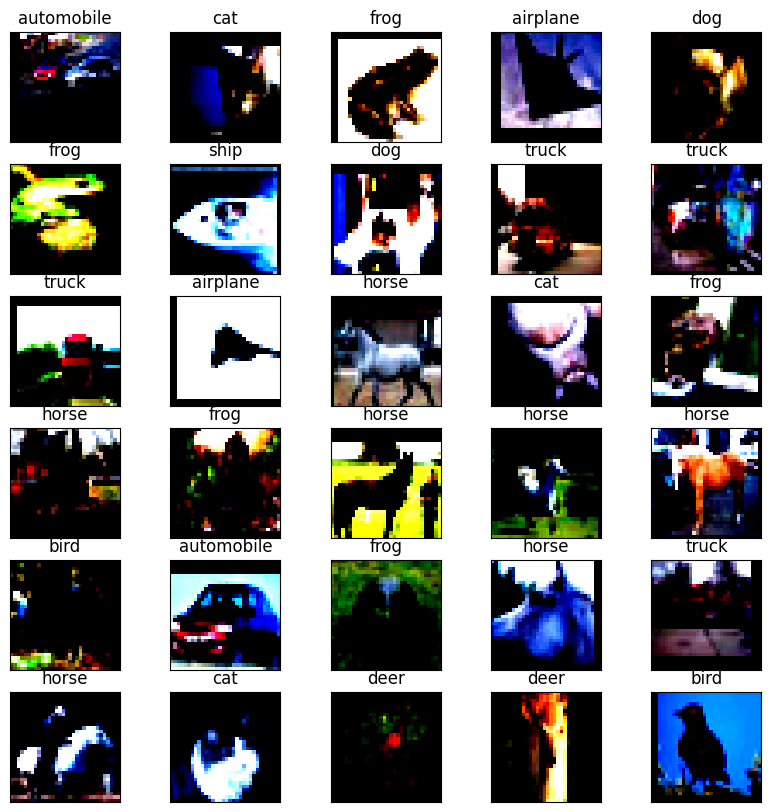

In [8]:
vis_images_train, vis_labels_train = next(iter(train_dataloader))
show(vis_images_train, vis_labels_train, classes=train_dataloader.dataset.classes)

print(vis_images_train.shape, vis_labels_train.shape)

torch.Size([512, 3, 32, 32]) torch.Size([512])


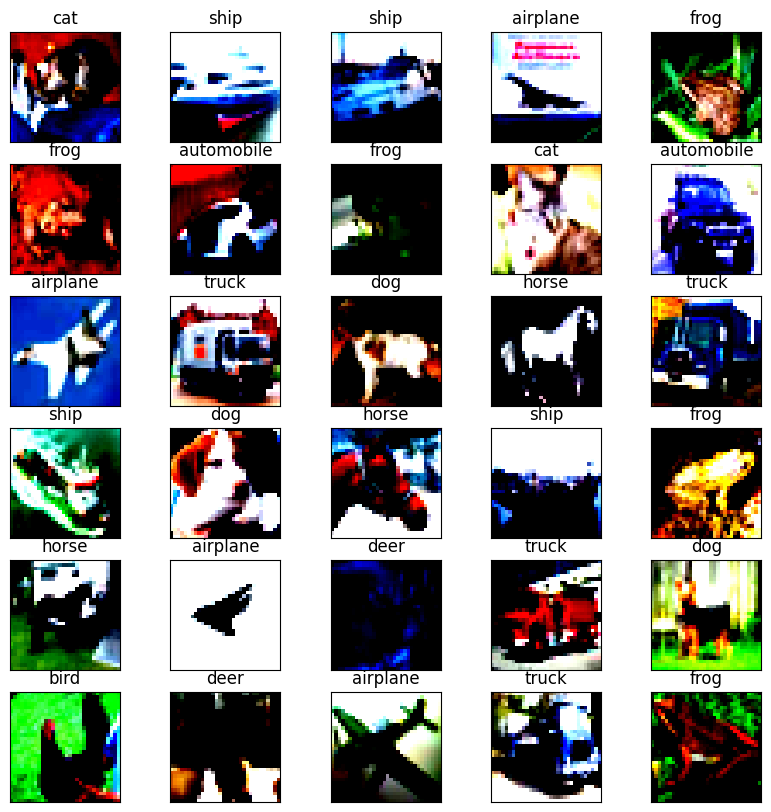

In [9]:
vis_images_val, vis_labels_val = next(iter(valid_dataloader))
show(vis_images_val, vis_labels_val, classes=train_dataloader.dataset.classes)

print(vis_images_val.shape, vis_labels_val.shape)

#Overide Parameters

Files already downloaded and verified


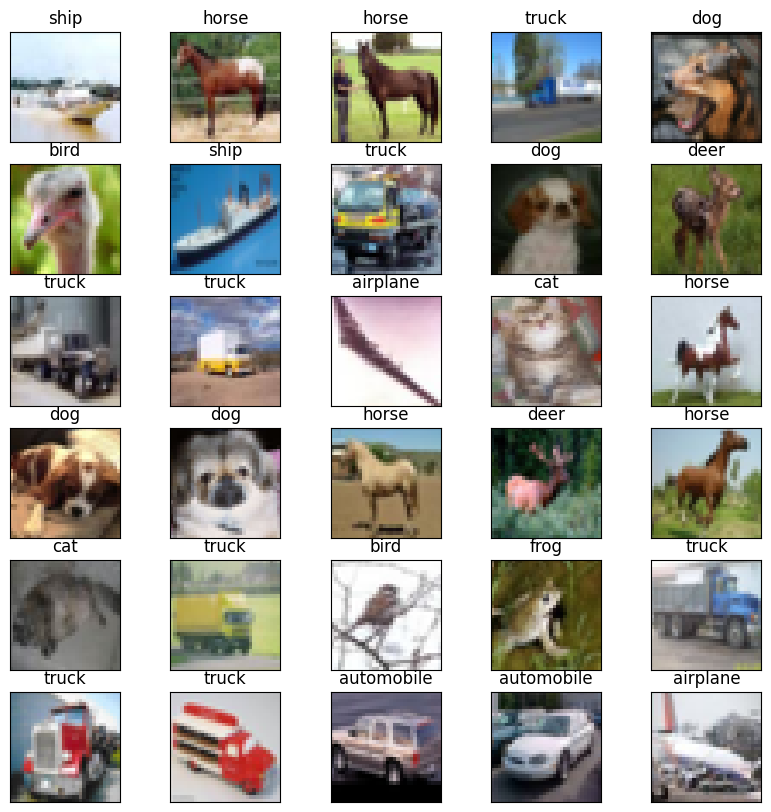

In [10]:
from torchvision import transforms as T
import torch

transforms_vis = [T.ToTensor()] # Let's just do nothing in transforms

vis_dataloader = dataloaders.get("cifar10_train",
                                dataset_params={"transforms": transforms_vis},
                                dataloader_params={"num_workers": 2})

vis_images, vis_labels = next(iter(vis_dataloader))

show(vis_images, vis_labels, classes=train_dataloader.dataset.classes)

#Architecture = Resnet18

In [11]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

model = models.get(model_name=Models.RESNET18, num_classes=10, pretrained_weights="imagenet")

[2024-01-24 18:22:18] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture resnet18


#Training

In [12]:
from super_gradients.training import Trainer
from super_gradients.training import training_hyperparams

# you can see more recipes in super_gradients/recipes
training_params =  training_hyperparams.get("training_hyperparams/cifar10_resnet_train_params")


/usr/local/lib/python3.10/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'training_hyperparams/cifar10_resnet_train_params': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [13]:
pprint.pprint("Training parameters")
pprint.pprint(training_params)

In [14]:
training_params["max_epochs"] = 15

In [15]:
trainer.train(model=model,
              training_params=training_params,
              train_loader=train_dataloader,
              valid_loader=valid_dataloader)

[2024-01-24 18:22:19] WARNING - sg_trainer.py - Train dataset size % batch_size != 0 and drop_last=False, this might result in smaller last batch.
[2024-01-24 18:22:19] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240124_182219_116529`
[2024-01-24 18:22:19] INFO - sg_trainer.py - Checkpoints directory: /home/notebook_ckpts/classification_transfer_learning/RUN_20240124_182219_116529


'Training parameters'
{'_convert_': 'all',
 'average_best_models': True,
 'batch_accumulate': 1,
 'ckpt_best_name': 'ckpt_best.pth',
 'ckpt_name': 'ckpt_latest.pth',
 'clip_grad_norm': None,
 'cosine_final_lr_ratio': 0.01,
 'criterion_params': {},
 'dataset_statistics': False,
 'ema': False,
 'ema_params': {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15},
 'greater_metric_to_watch_is_better': True,
 'initial_lr': 0.1,
 'launch_tensorboard': False,
 'load_opt_params': True,
 'log_installed_packages': True,
 'loss': 'LabelSmoothingCrossEntropyLoss',
 'lr_cooldown_epochs': 0,
 'lr_decay_factor': 0.1,
 'lr_mode': 'StepLRScheduler',
 'lr_schedule_function': None,
 'lr_updates': array([100, 150, 200]),
 'lr_warmup_epochs': 0,
 'lr_warmup_steps': 0,
 'max_epochs': 250,
 'max_train_batches': None,
 'max_valid_batches': None,
 'metric_to_watch': 'Accuracy',
 'mixed_precision': False,
 'optimizer': 'SGD',
 'optimizer_params': {'weight_decay': 0.0001, 'momentum': 0.9},
 'phase_callbacks': [],
 

[2024-01-24 18:22:20] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            50000      (len(train_set))
    - Batch size per GPU:           256        (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             256        (num_gpus * batch_size)
    - Effective Batch size:         256        (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         196        (len(train_loader))
    - Gradient updates per epoch:   196        (len(train_loader) / batch_accumulate)
    - Model: ResNet18  (11.18M parameters, 11.18M optimized)
    - Learning Rates and Weight Decays:
      - default: (11.18M parameters). LR: 0.1 (11.18M parameters) WD: 0.0001, (11.18M parameters)

[2024-01-24 18:22:20] INFO - sg_trainer.py - Started training for 15 epochs (0/14)

Validating: 100%|

SUMMARY OF EPOCH 0
├── Train
│   ├── Labelsmoothingcrossentropyloss = 3.0471
│   ├── Accuracy = 0.1533
│   └── Top5 = 0.6456
└── Validation
    ├── Labelsmoothingcrossentropyloss = 2.0072
    ├── Accuracy = 0.2081
    └── Top5 = 0.8032



Validating epoch 1: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]
[2024-01-24 18:35:02] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20240124_182219_116529/ckpt_best.pth
[2024-01-24 18:35:02] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.31790000200271606


SUMMARY OF EPOCH 1
├── Train
│   ├── Labelsmoothingcrossentropyloss = 2.0015
│   │   ├── Epoch N-1      = 3.0471 (↘ -1.0456)
│   │   └── Best until now = 3.0471 (↘ -1.0456)
│   ├── Accuracy = 0.2718
│   │   ├── Epoch N-1      = 0.1533 (↗ 0.1186)
│   │   └── Best until now = 0.1533 (↗ 0.1186)
│   └── Top5 = 0.8474
│       ├── Epoch N-1      = 0.6456 (↗ 0.2018)
│       └── Best until now = 0.6456 (↗ 0.2018)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 2.3656
    │   ├── Epoch N-1      = 2.0072 (↗ 0.3584)
    │   └── Best until now = 2.0072 (↗ 0.3584)
    ├── Accuracy = 0.3179
    │   ├── Epoch N-1      = 0.2081 (↗ 0.1098)
    │   └── Best until now = 0.2081 (↗ 0.1098)
    └── Top5 = 0.8784
        ├── Epoch N-1      = 0.8032 (↗ 0.0752)
        └── Best until now = 0.8032 (↗ 0.0752)



Validating epoch 2: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]
[2024-01-24 18:41:23] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20240124_182219_116529/ckpt_best.pth
[2024-01-24 18:41:23] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.42250001430511475


SUMMARY OF EPOCH 2
├── Train
│   ├── Labelsmoothingcrossentropyloss = 1.7925
│   │   ├── Epoch N-1      = 2.0015 (↘ -0.209)
│   │   └── Best until now = 2.0015 (↘ -0.209)
│   ├── Accuracy = 0.3425
│   │   ├── Epoch N-1      = 0.2718 (↗ 0.0707)
│   │   └── Best until now = 0.2718 (↗ 0.0707)
│   └── Top5 = 0.8821
│       ├── Epoch N-1      = 0.8474 (↗ 0.0347)
│       └── Best until now = 0.8474 (↗ 0.0347)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 1.6631
    │   ├── Epoch N-1      = 2.3656 (↘ -0.7025)
    │   └── Best until now = 2.0072 (↘ -0.3442)
    ├── Accuracy = 0.4225
    │   ├── Epoch N-1      = 0.3179 (↗ 0.1046)
    │   └── Best until now = 0.3179 (↗ 0.1046)
    └── Top5 = 0.9115
        ├── Epoch N-1      = 0.8784 (↗ 0.0331)
        └── Best until now = 0.8784 (↗ 0.0331)



Validating epoch 3: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
[2024-01-24 18:47:46] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20240124_182219_116529/ckpt_best.pth
[2024-01-24 18:47:46] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.4417000114917755


SUMMARY OF EPOCH 3
├── Train
│   ├── Labelsmoothingcrossentropyloss = 1.6252
│   │   ├── Epoch N-1      = 1.7925 (↘ -0.1673)
│   │   └── Best until now = 1.7925 (↘ -0.1673)
│   ├── Accuracy = 0.4029
│   │   ├── Epoch N-1      = 0.3425 (↗ 0.0604)
│   │   └── Best until now = 0.3425 (↗ 0.0604)
│   └── Top5 = 0.9
│       ├── Epoch N-1      = 0.8821 (↗ 0.018)
│       └── Best until now = 0.8821 (↗ 0.018)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 1.5197
    │   ├── Epoch N-1      = 1.6631 (↘ -0.1434)
    │   └── Best until now = 1.6631 (↘ -0.1434)
    ├── Accuracy = 0.4417
    │   ├── Epoch N-1      = 0.4225 (↗ 0.0192)
    │   └── Best until now = 0.4225 (↗ 0.0192)
    └── Top5 = 0.9177
        ├── Epoch N-1      = 0.9115 (↗ 0.0062)
        └── Best until now = 0.9115 (↗ 0.0062)



Validating epoch 4: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
[2024-01-24 18:54:14] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20240124_182219_116529/ckpt_best.pth
[2024-01-24 18:54:14] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.5274999737739563


SUMMARY OF EPOCH 4
├── Train
│   ├── Labelsmoothingcrossentropyloss = 1.4747
│   │   ├── Epoch N-1      = 1.6252 (↘ -0.1504)
│   │   └── Best until now = 1.6252 (↘ -0.1504)
│   ├── Accuracy = 0.4635
│   │   ├── Epoch N-1      = 0.4029 (↗ 0.0606)
│   │   └── Best until now = 0.4029 (↗ 0.0606)
│   └── Top5 = 0.9196
│       ├── Epoch N-1      = 0.9    (↗ 0.0196)
│       └── Best until now = 0.9    (↗ 0.0196)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 1.304
    │   ├── Epoch N-1      = 1.5197 (↘ -0.2157)
    │   └── Best until now = 1.5197 (↘ -0.2157)
    ├── Accuracy = 0.5275
    │   ├── Epoch N-1      = 0.4417 (↗ 0.0858)
    │   └── Best until now = 0.4417 (↗ 0.0858)
    └── Top5 = 0.943
        ├── Epoch N-1      = 0.9177 (↗ 0.0253)
        └── Best until now = 0.9177 (↗ 0.0253)



Validating epoch 5: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]
[2024-01-24 19:00:41] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20240124_182219_116529/ckpt_best.pth
[2024-01-24 19:00:41] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.5516999959945679


SUMMARY OF EPOCH 5
├── Train
│   ├── Labelsmoothingcrossentropyloss = 1.326
│   │   ├── Epoch N-1      = 1.4747 (↘ -0.1487)
│   │   └── Best until now = 1.4747 (↘ -0.1487)
│   ├── Accuracy = 0.5175
│   │   ├── Epoch N-1      = 0.4635 (↗ 0.054)
│   │   └── Best until now = 0.4635 (↗ 0.054)
│   └── Top5 = 0.9394
│       ├── Epoch N-1      = 0.9196 (↗ 0.0198)
│       └── Best until now = 0.9196 (↗ 0.0198)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 1.2311
    │   ├── Epoch N-1      = 1.304  (↘ -0.0729)
    │   └── Best until now = 1.304  (↘ -0.0729)
    ├── Accuracy = 0.5517
    │   ├── Epoch N-1      = 0.5275 (↗ 0.0242)
    │   └── Best until now = 0.5275 (↗ 0.0242)
    └── Top5 = 0.9481
        ├── Epoch N-1      = 0.943  (↗ 0.0051)
        └── Best until now = 0.943  (↗ 0.0051)



Validating epoch 6: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]
[2024-01-24 19:07:05] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20240124_182219_116529/ckpt_best.pth
[2024-01-24 19:07:05] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.5752000212669373


SUMMARY OF EPOCH 6
├── Train
│   ├── Labelsmoothingcrossentropyloss = 1.2328
│   │   ├── Epoch N-1      = 1.326  (↘ -0.0932)
│   │   └── Best until now = 1.326  (↘ -0.0932)
│   ├── Accuracy = 0.5542
│   │   ├── Epoch N-1      = 0.5175 (↗ 0.0368)
│   │   └── Best until now = 0.5175 (↗ 0.0368)
│   └── Top5 = 0.9483
│       ├── Epoch N-1      = 0.9394 (↗ 0.0089)
│       └── Best until now = 0.9394 (↗ 0.0089)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 1.1972
    │   ├── Epoch N-1      = 1.2311 (↘ -0.0339)
    │   └── Best until now = 1.2311 (↘ -0.0339)
    ├── Accuracy = 0.5752
    │   ├── Epoch N-1      = 0.5517 (↗ 0.0235)
    │   └── Best until now = 0.5517 (↗ 0.0235)
    └── Top5 = 0.9547
        ├── Epoch N-1      = 0.9481 (↗ 0.0066)
        └── Best until now = 0.9481 (↗ 0.0066)



Validating epoch 7: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]
[2024-01-24 19:13:34] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20240124_182219_116529/ckpt_best.pth
[2024-01-24 19:13:34] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.6132000088691711


SUMMARY OF EPOCH 7
├── Train
│   ├── Labelsmoothingcrossentropyloss = 1.1497
│   │   ├── Epoch N-1      = 1.2328 (↘ -0.0831)
│   │   └── Best until now = 1.2328 (↘ -0.0831)
│   ├── Accuracy = 0.5848
│   │   ├── Epoch N-1      = 0.5542 (↗ 0.0305)
│   │   └── Best until now = 0.5542 (↗ 0.0305)
│   └── Top5 = 0.9576
│       ├── Epoch N-1      = 0.9483 (↗ 0.0093)
│       └── Best until now = 0.9483 (↗ 0.0093)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 1.0814
    │   ├── Epoch N-1      = 1.1972 (↘ -0.1158)
    │   └── Best until now = 1.1972 (↘ -0.1158)
    ├── Accuracy = 0.6132
    │   ├── Epoch N-1      = 0.5752 (↗ 0.038)
    │   └── Best until now = 0.5752 (↗ 0.038)
    └── Top5 = 0.9606
        ├── Epoch N-1      = 0.9547 (↗ 0.0059)
        └── Best until now = 0.9547 (↗ 0.0059)



Validating epoch 8: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]
[2024-01-24 19:20:07] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20240124_182219_116529/ckpt_best.pth
[2024-01-24 19:20:07] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.6152999997138977


SUMMARY OF EPOCH 8
├── Train
│   ├── Labelsmoothingcrossentropyloss = 1.0722
│   │   ├── Epoch N-1      = 1.1497 (↘ -0.0775)
│   │   └── Best until now = 1.1497 (↘ -0.0775)
│   ├── Accuracy = 0.6147
│   │   ├── Epoch N-1      = 0.5848 (↗ 0.03)
│   │   └── Best until now = 0.5848 (↗ 0.03)
│   └── Top5 = 0.964
│       ├── Epoch N-1      = 0.9576 (↗ 0.0064)
│       └── Best until now = 0.9576 (↗ 0.0064)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 1.1049
    │   ├── Epoch N-1      = 1.0814 (↗ 0.0235)
    │   └── Best until now = 1.0814 (↗ 0.0235)
    ├── Accuracy = 0.6153
    │   ├── Epoch N-1      = 0.6132 (↗ 0.0021)
    │   └── Best until now = 0.6132 (↗ 0.0021)
    └── Top5 = 0.965
        ├── Epoch N-1      = 0.9606 (↗ 0.0044)
        └── Best until now = 0.9606 (↗ 0.0044)



Validating epoch 9: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Labelsmoothingcrossentropyloss = 1.0214
│   │   ├── Epoch N-1      = 1.0722 (↘ -0.0508)
│   │   └── Best until now = 1.0722 (↘ -0.0508)
│   ├── Accuracy = 0.6347
│   │   ├── Epoch N-1      = 0.6147 (↗ 0.0199)
│   │   └── Best until now = 0.6147 (↗ 0.0199)
│   └── Top5 = 0.9671
│       ├── Epoch N-1      = 0.964  (↗ 0.0031)
│       └── Best until now = 0.964  (↗ 0.0031)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 1.1795
    │   ├── Epoch N-1      = 1.1049 (↗ 0.0746)
    │   └── Best until now = 1.0814 (↗ 0.0981)
    ├── Accuracy = 0.6088
    │   ├── Epoch N-1      = 0.6153 (↘ -0.0065)
    │   └── Best until now = 0.6153 (↘ -0.0065)
    └── Top5 = 0.9571
        ├── Epoch N-1      = 0.965  (↘ -0.0079)
        └── Best until now = 0.965  (↘ -0.0079)



Validating epoch 10: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]
[2024-01-24 19:33:04] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20240124_182219_116529/ckpt_best.pth
[2024-01-24 19:33:04] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.673799991607666


SUMMARY OF EPOCH 10
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.9715
│   │   ├── Epoch N-1      = 1.0214 (↘ -0.0499)
│   │   └── Best until now = 1.0214 (↘ -0.0499)
│   ├── Accuracy = 0.6553
│   │   ├── Epoch N-1      = 0.6347 (↗ 0.0206)
│   │   └── Best until now = 0.6347 (↗ 0.0206)
│   └── Top5 = 0.9704
│       ├── Epoch N-1      = 0.9671 (↗ 0.0033)
│       └── Best until now = 0.9671 (↗ 0.0033)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.9441
    │   ├── Epoch N-1      = 1.1795 (↘ -0.2354)
    │   └── Best until now = 1.0814 (↘ -0.1373)
    ├── Accuracy = 0.6738
    │   ├── Epoch N-1      = 0.6088 (↗ 0.065)
    │   └── Best until now = 0.6153 (↗ 0.0585)
    └── Top5 = 0.9737
        ├── Epoch N-1      = 0.9571 (↗ 0.0166)
        └── Best until now = 0.965  (↗ 0.0087)



Validating epoch 11: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.9127
│   │   ├── Epoch N-1      = 0.9715 (↘ -0.0588)
│   │   └── Best until now = 0.9715 (↘ -0.0588)
│   ├── Accuracy = 0.6766
│   │   ├── Epoch N-1      = 0.6553 (↗ 0.0213)
│   │   └── Best until now = 0.6553 (↗ 0.0213)
│   └── Top5 = 0.9747
│       ├── Epoch N-1      = 0.9704 (↗ 0.0043)
│       └── Best until now = 0.9704 (↗ 0.0043)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.981
    │   ├── Epoch N-1      = 0.9441 (↗ 0.0368)
    │   └── Best until now = 0.9441 (↗ 0.0368)
    ├── Accuracy = 0.656
    │   ├── Epoch N-1      = 0.6738 (↘ -0.0178)
    │   └── Best until now = 0.6738 (↘ -0.0178)
    └── Top5 = 0.9738
        ├── Epoch N-1      = 0.9737 (↗ 0.0001)
        └── Best until now = 0.9737 (↗ 0.0001)



Validating epoch 12: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
[2024-01-24 19:46:06] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20240124_182219_116529/ckpt_best.pth
[2024-01-24 19:46:06] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.7024999856948853


SUMMARY OF EPOCH 12
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.8796
│   │   ├── Epoch N-1      = 0.9127 (↘ -0.0331)
│   │   └── Best until now = 0.9127 (↘ -0.0331)
│   ├── Accuracy = 0.6891
│   │   ├── Epoch N-1      = 0.6766 (↗ 0.0126)
│   │   └── Best until now = 0.6766 (↗ 0.0126)
│   └── Top5 = 0.9766
│       ├── Epoch N-1      = 0.9747 (↗ 0.0018)
│       └── Best until now = 0.9747 (↗ 0.0018)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.8631
    │   ├── Epoch N-1      = 0.981  (↘ -0.1179)
    │   └── Best until now = 0.9441 (↘ -0.081)
    ├── Accuracy = 0.7025
    │   ├── Epoch N-1      = 0.656  (↗ 0.0465)
    │   └── Best until now = 0.6738 (↗ 0.0287)
    └── Top5 = 0.9785
        ├── Epoch N-1      = 0.9738 (↗ 0.0047)
        └── Best until now = 0.9738 (↗ 0.0047)



Validating epoch 13: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]
[2024-01-24 19:52:31] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20240124_182219_116529/ckpt_best.pth
[2024-01-24 19:52:31] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.7045999765396118


SUMMARY OF EPOCH 13
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.8512
│   │   ├── Epoch N-1      = 0.8796 (↘ -0.0284)
│   │   └── Best until now = 0.8796 (↘ -0.0284)
│   ├── Accuracy = 0.7002
│   │   ├── Epoch N-1      = 0.6891 (↗ 0.0111)
│   │   └── Best until now = 0.6891 (↗ 0.0111)
│   └── Top5 = 0.9778
│       ├── Epoch N-1      = 0.9766 (↗ 0.0012)
│       └── Best until now = 0.9766 (↗ 0.0012)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.8507
    │   ├── Epoch N-1      = 0.8631 (↘ -0.0124)
    │   └── Best until now = 0.8631 (↘ -0.0124)
    ├── Accuracy = 0.7046
    │   ├── Epoch N-1      = 0.7025 (↗ 0.0021)
    │   └── Best until now = 0.7025 (↗ 0.0021)
    └── Top5 = 0.9789
        ├── Epoch N-1      = 0.9785 (↗ 0.0004)
        └── Best until now = 0.9785 (↗ 0.0004)



Validating epoch 14: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.8114
│   │   ├── Epoch N-1      = 0.8512 (↘ -0.0398)
│   │   └── Best until now = 0.8512 (↘ -0.0398)
│   ├── Accuracy = 0.7137
│   │   ├── Epoch N-1      = 0.7002 (↗ 0.0135)
│   │   └── Best until now = 0.7002 (↗ 0.0135)
│   └── Top5 = 0.9797
│       ├── Epoch N-1      = 0.9778 (↗ 0.0019)
│       └── Best until now = 0.9778 (↗ 0.0019)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.9368
    │   ├── Epoch N-1      = 0.8507 (↗ 0.0861)
    │   └── Best until now = 0.8507 (↗ 0.0861)
    ├── Accuracy = 0.6806
    │   ├── Epoch N-1      = 0.7046 (↘ -0.024)
    │   └── Best until now = 0.7046 (↘ -0.024)
    └── Top5 = 0.9749
        ├── Epoch N-1      = 0.9789 (↘ -0.004)
        └── Best until now = 0.9789 (↘ -0.004)



[2024-01-24 19:59:04] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 15:  95%|█████████▌| 19/20 [00:18<00:00,  1.21it/s]

#Predict

Validating epoch 15: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]
[2024-01-24 19:59:23] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
[2024-01-24 19:59:23] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/notebook_ckpts/classification_transfer_learning/RUN_20240124_182219_116529/ckpt_best.pth checkpoint.
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2024-01-24 19:59:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


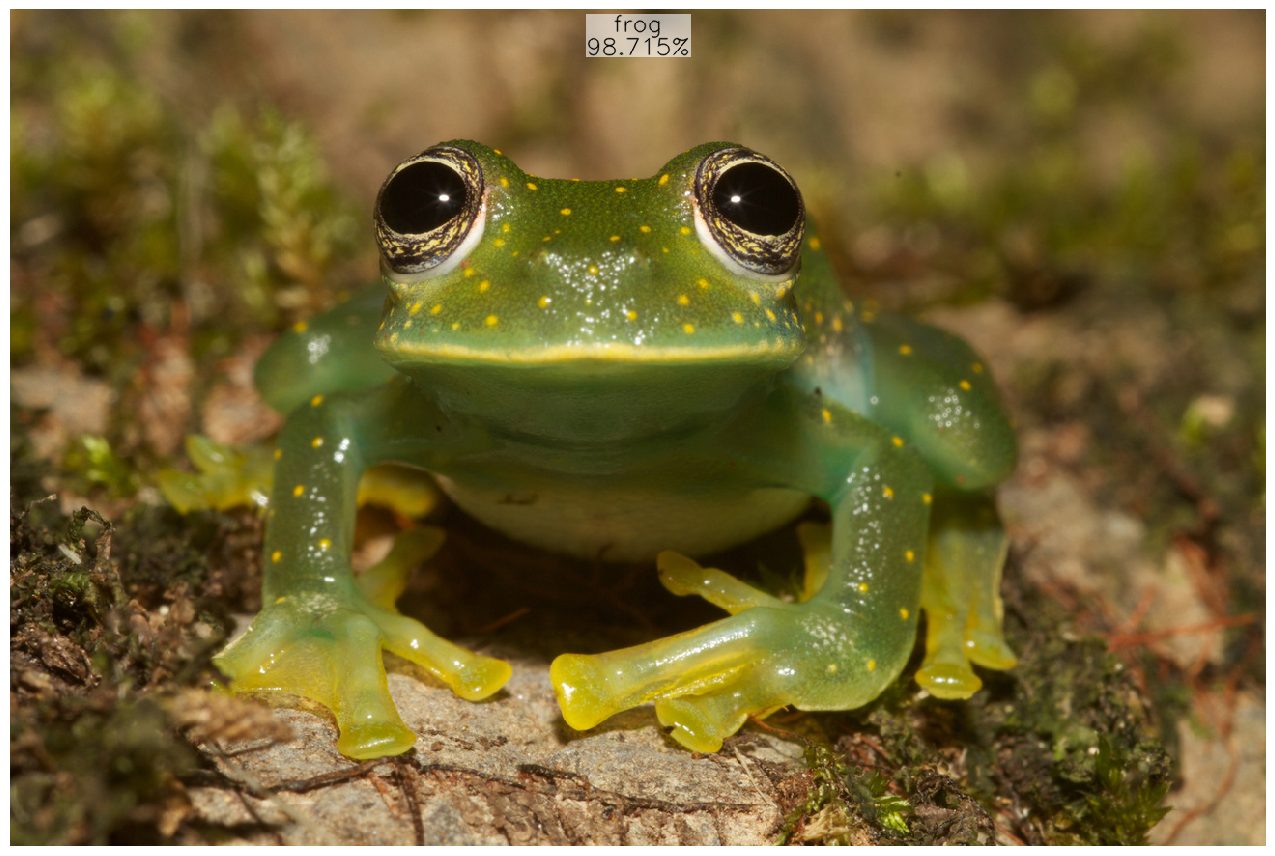

In [16]:
from PIL import Image
import numpy as np
import requests
import os
from super_gradients.training.processing.processing import ComposeProcessing, NormalizeImage, Resize, StandardizeImage, ImagePermute

# Load the best model that we trained
best_model = models.get(Models.RESNET18,
                        num_classes=10,
                        checkpoint_path=os.path.join(trainer.checkpoints_dir_path,"ckpt_best.pth"))
best_model.eval()

image_processor = ComposeProcessing(
    [Resize(size=64), StandardizeImage(),
     NormalizeImage(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]), ImagePermute()]
)

classes = train_dataloader.dataset.classes

best_model.set_dataset_processing_params(image_processor=image_processor, class_names=classes)

prediction = best_model.predict("https://d1jyxxz9imt9yb.cloudfront.net/medialib/3078/image/s1300x1300/IP202207_GlassFrogs_009_365211_reduced.jpg")


prediction.show()

#Convert to ONNX

In [17]:
import torch
onnx_filename = f"{experiment_name}_{model_name}.onnx"

best_model.eval()
best_model.prep_model_for_conversion(input_size=[1, 3, 32, 32]) # image shape of CIFAR10 images
dummy_input = torch.randn([1, 3, 32, 32], device=next(best_model.parameters()).device)

torch.onnx.export(best_model, dummy_input, onnx_filename)